In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

import statsmodels.api as sm
import scipy.stats as stats

In [2]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
sns.set()
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

#### Train on model with plain stats

In [4]:
model_df1 = pd.read_csv('../dataset/model_df1.csv')

In [5]:
print(model_df1.shape)

(21361, 74)


In [6]:
# Drop columns resulted from EDA
columns_to_drop = ['dribbling_MF_home', 'dribbling_SB_home', 'dribbling_ST_home','dribbling_W_home', 
      'dribbling_MF_away', 'dribbling_SB_away', 'dribbling_ST_away', 'dribbling_W_away',
      'shooting_MF_home', 'shooting_MF_away', 'defence_MF_home', 'defence_MF_away']
model_df1 = model_df1.drop(columns = columns_to_drop)

In [7]:
X = model_df1.drop(columns = 'result')

In [8]:
# Drop outliers
z_scores = np.abs((X - X.mean()) / X.std())
outliers = z_scores > 4
outliers_rows = model_df1[outliers.any(axis=1)]
outlier_indices = outliers_rows.index
model_df1 = model_df1.drop(outlier_indices)

In [9]:
model_df1.isna().sum()

match_api_id               0
dribbling_CB_home          0
dribbling_GK_home          0
sprint_speed_CB_home       0
sprint_speed_GK_home       0
sprint_speed_MF_home       0
sprint_speed_SB_home    1251
sprint_speed_ST_home       0
sprint_speed_W_home     1799
passing_CB_home            0
passing_GK_home            0
passing_MF_home            0
passing_SB_home         1251
passing_ST_home            0
passing_W_home          1799
shooting_CB_home           0
shooting_GK_home           0
shooting_SB_home        1251
shooting_ST_home           0
shooting_W_home         1799
defence_CB_home            0
defence_GK_home            0
defence_SB_home         1251
defence_ST_home            0
defence_W_home          1799
goalkeeping_CB_home        0
goalkeeping_GK_home        0
goalkeeping_MF_home        0
goalkeeping_SB_home     1251
goalkeeping_ST_home        0
goalkeeping_W_home      1799
dribbling_CB_away          0
dribbling_GK_away          0
sprint_speed_CB_away       0
sprint_speed_G

In [10]:
model_df1 = model_df1.dropna()

In [11]:
model_df1 = model_df1.drop(columns = 'match_api_id')

In [12]:
print(model_df1.shape)
model_df1.head()

(15720, 61)


,dribbling_CB_home,dribbling_GK_home,sprint_speed_CB_home,sprint_speed_GK_home,sprint_speed_MF_home,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_GK_home,...,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_CB_away,goalkeeping_GK_away,goalkeeping_MF_away,goalkeeping_SB_away,goalkeeping_ST_away,goalkeeping_W_away,result
0,51.0,21.0,72.0,67.0,74.50,76.5,78.5,71.5,59.67,41.33,...,64.50,36.71,61.75,25.7,73.0,29.30,26.40,22.9,26.00,win
1,36.5,22.0,61.0,34.0,70.00,51.0,70.5,62.0,53.17,38.33,...,63.62,32.50,34.12,28.9,69.4,25.33,28.60,19.2,25.70,win
4,55.0,22.0,75.0,52.0,71.67,64.0,64.0,78.5,71.00,38.33,...,72.62,37.75,60.38,28.8,67.2,29.40,28.60,26.2,28.30,tie
5,45.5,17.0,61.5,46.0,77.50,71.0,72.5,75.5,58.33,34.83,...,65.50,36.67,51.31,26.8,72.0,26.70,24.60,22.3,20.45,lose
6,39.5,20.0,64.0,60.0,64.00,74.5,61.0,73.0,58.17,41.00,...,69.56,31.50,56.12,26.1,74.8,24.23,17.75,10.4,24.65,win


In [13]:
def get_importance(df, target):
    '''
    Train a Random Forest Classifier on the given DataFrame `df` to predict the `target` column. 
    Show confusion matrix and plot feature importance     
    
    Args: df(dataframe): dataframe in format that fits Random Forest Classifier
          target(string): dependent variable
    '''
        
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)
    
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    feature_importances = rf_model.feature_importances_
    features = X_train.columns
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show()  
    
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sorted_feature_importance_df = sorted_feature_importance_df.reset_index(drop = True)
    print(sorted_feature_importance_df)

    plt.figure(figsize=(12, 4))
    plt.bar(sorted_feature_importance_df['Feature'], sorted_feature_importance_df['Importance'], color = 'lavender')
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances in Random Forest')
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

        lose       0.51      0.45      0.48      1144
         tie       0.22      0.03      0.05       963
         win       0.54      0.83      0.66      1823

    accuracy                           0.53      3930
   macro avg       0.43      0.44      0.40      3930
weighted avg       0.46      0.53      0.46      3930



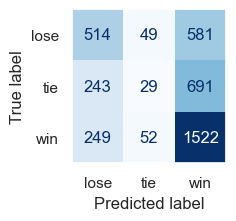

                 Feature  Importance
0        defence_CB_home    0.025738
1        defence_CB_away    0.023446
2        passing_MF_away    0.023096
3        passing_MF_home    0.022275
4       shooting_ST_home    0.021417
5        defence_SB_home    0.020610
6        defence_SB_away    0.020321
7       shooting_ST_away    0.020170
8         passing_W_home    0.019899
9        passing_SB_away    0.019841
10       passing_SB_home    0.019719
11       shooting_W_home    0.019624
12   goalkeeping_GK_away    0.018654
13   goalkeeping_GK_home    0.018363
14       shooting_W_away    0.018184
15      shooting_CB_home    0.018078
16       passing_ST_away    0.018054
17  sprint_speed_SB_away    0.017960
18  sprint_speed_MF_away    0.017881
19        passing_W_away    0.017697
20      shooting_SB_away    0.017482
21       passing_CB_home    0.017241
22       passing_ST_home    0.017137
23     dribbling_CB_home    0.016937
24      shooting_CB_away    0.016780
25        defence_W_away    0.016737
2

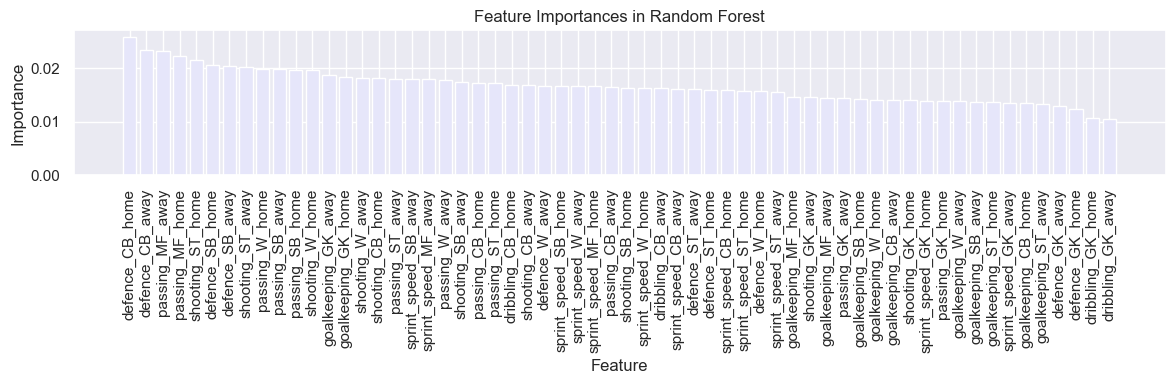

In [14]:
# Check feature importance
get_importance(model_df1, 'result')

In [15]:
# Drop features with importance less than 0.015
col_to_drop = ['goalkeeping_MF_away', 'goalkeeping_MF_home', 'passing_GK_away', 'goalkeeping_W_home', 'goalkeeping_W_away',
               'shooting_GK_away', 'passing_GK_home', 'goalkeeping_ST_home', 'sprint_speed_GK_home', 'goalkeeping_CB_away',
               'goalkeeping_SB_home', 'goalkeeping_ST_away', 'goalkeeping_SB_away', 'shooting_GK_home', 'sprint_speed_GK_away',
               'goalkeeping_CB_home', 'defence_GK_away', 'defence_GK_home', 'dribbling_GK_away', 'dribbling_GK_home']

In [16]:
model_df1 = model_df1.drop(columns = col_to_drop)

              precision    recall  f1-score   support

        lose       0.50      0.45      0.47      1144
         tie       0.23      0.03      0.06       963
         win       0.55      0.83      0.66      1823

    accuracy                           0.53      3930
   macro avg       0.43      0.44      0.40      3930
weighted avg       0.46      0.53      0.46      3930



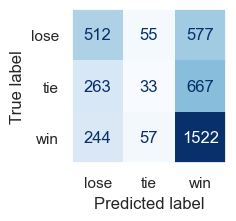

                 Feature  Importance
0        defence_CB_home    0.032770
1        passing_MF_away    0.031871
2        passing_MF_home    0.030850
3        defence_CB_away    0.029963
4       shooting_ST_away    0.027806
5        defence_SB_home    0.027696
6       shooting_ST_home    0.027544
7        defence_SB_away    0.027394
8        passing_SB_away    0.027150
9        passing_SB_home    0.026206
10        passing_W_home    0.026159
11       shooting_W_home    0.025857
12   goalkeeping_GK_away    0.025214
13       passing_ST_away    0.025157
14       shooting_W_away    0.024712
15       passing_CB_home    0.024374
16     dribbling_CB_home    0.024318
17        passing_W_away    0.024312
18   sprint_speed_W_away    0.024282
19      shooting_CB_home    0.024257
20      shooting_SB_away    0.024169
21   goalkeeping_GK_home    0.024162
22  sprint_speed_SB_away    0.024004
23     dribbling_CB_away    0.023757
24       passing_ST_home    0.023574
25  sprint_speed_MF_away    0.023472
2

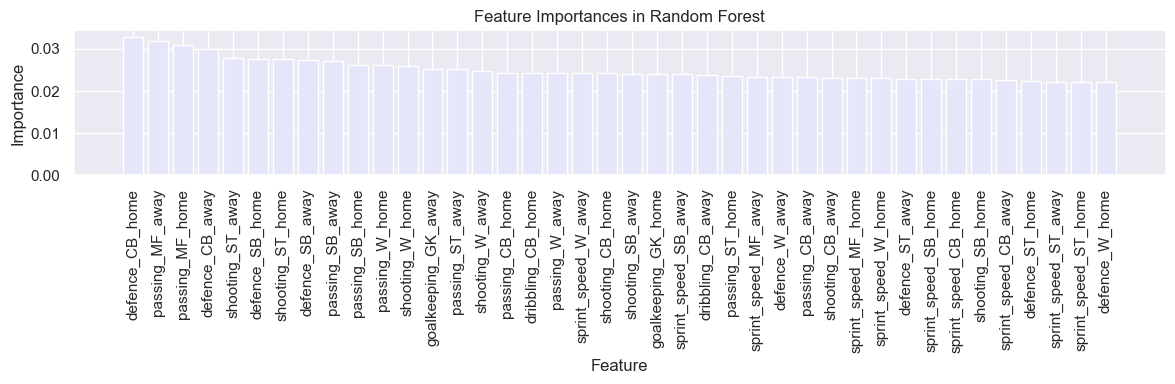

In [17]:
get_importance(model_df1, 'result')

In [18]:
X = model_df1.drop(columns = 'result')

In [19]:
bin_edges_dict = {}
num_bins = 5
bin_labels = [0,1,2,3,4]
for col in X.columns:
    model_df1[col], bin_edges = pd.qcut(model_df1[col], labels = bin_labels, 
                                            q=num_bins, retbins=True)
    bin_edges_dict[col] = bin_edges
    bin_edge_df = pd.DataFrame(zip(bin_edges, bin_labels), columns=['Threshold', 'Tier'])
    #print(bin_edge_df)

In [20]:
model_df1['result'] = model_df1['result'].replace({'win': 2, 'tie': 1, 'lose':0})

In [21]:
model_df1['result'] = model_df1['result'].astype('category')

In [22]:
model_df1.head()

,dribbling_CB_home,sprint_speed_CB_home,sprint_speed_MF_home,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,...,shooting_CB_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_GK_away,result
0,3,4,4,3,3,0,3,4,1,3,...,2,2,1,3,1,1,3,4,2,2
1,0,1,2,0,1,0,1,1,0,2,...,4,4,3,1,1,0,3,1,1,2
4,3,4,3,0,0,2,4,1,0,0,...,3,4,1,3,3,3,3,4,1,1
5,1,1,4,1,1,1,2,3,0,1,...,4,0,2,0,1,1,3,3,2,0
6,0,2,1,2,0,1,2,1,1,1,...,2,4,3,3,2,2,2,4,2,2


In [23]:
lr_pipeline = Pipeline([('lr', LogisticRegression())])
rf_pipeline = Pipeline([('rf', RandomForestClassifier())])
nb_pipeline = Pipeline([('nb', GaussianNB())])
xgb_pipeline = Pipeline([('xgb', XGBClassifier())])

pipelines = [lr_pipeline, rf_pipeline, nb_pipeline, xgb_pipeline]

In [24]:
def get_best_model(df, target, scale = True, oversampler = False):
    '''
    Train multiple classifier model on the given DataFrame `df` to predict the specified `target` column. 
    Print accuracy score of all models and print the confusion matrix of the one with highest score.   
    
    Args: df(dataframe): dataframe in format that fits models in pipelines
          target(string): dependent variable    
          scale(boolean): scaler or not
          oversampler(boolean): oversampler or not
    '''    
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], test_size=0.25, 
                                                    random_state=47)
    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    
    if oversampler == True:
        oversampler = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
    

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

    for pipeline, ax in zip(pipelines, axes.flatten()):
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        model_name = pipeline.steps[-1][1].__class__.__name__
        
        print(model_name)
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)

        # Plot the confusion matrix horizontally
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        ax.grid(False)
        ax.set_title(f'Confusion Matrix - {model_name}')

    plt.tight_layout()
    plt.show()

LogisticRegression
              precision    recall  f1-score   support

           0       0.48      0.56      0.52      1144
           1       0.27      0.25      0.26       963
           2       0.62      0.58      0.60      1823

    accuracy                           0.49      3930
   macro avg       0.46      0.46      0.46      3930
weighted avg       0.49      0.49      0.49      3930

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1144
           1       0.30      0.11      0.16       963
           2       0.58      0.77      0.66      1823

    accuracy                           0.53      3930
   macro avg       0.46      0.46      0.44      3930
weighted avg       0.49      0.53      0.49      3930

GaussianNB
              precision    recall  f1-score   support

           0       0.47      0.54      0.50      1144
           1       0.27      0.28      0.27       963
           2       0.6

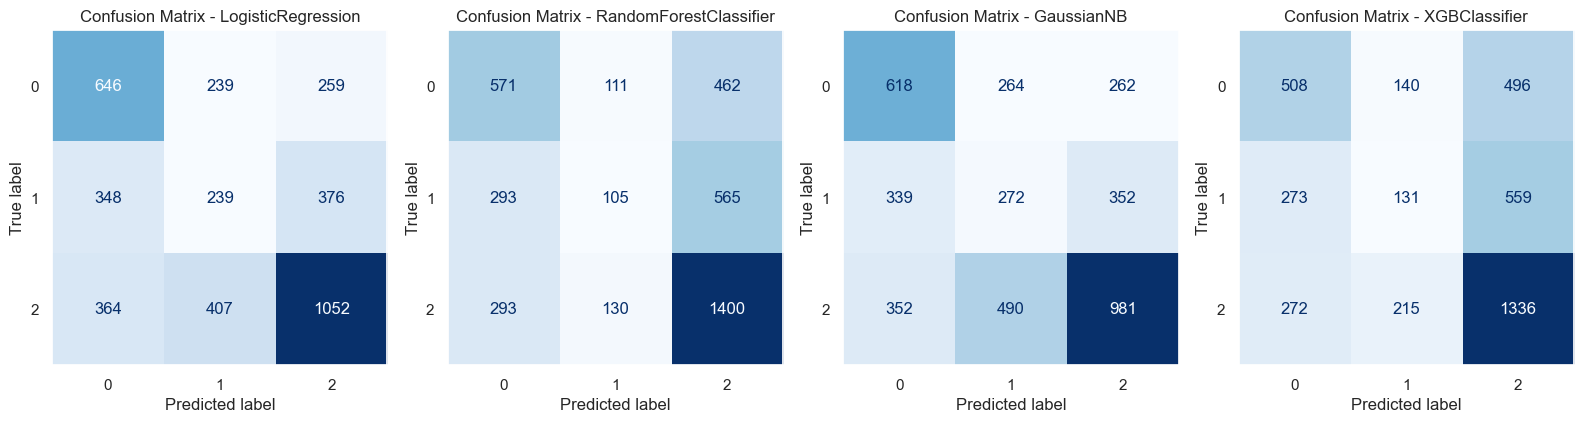

In [25]:
get_best_model(model_df1, 'result', oversampler = True)

In [26]:
def logistic_Grid_CV(df, target, scale = True, oversampler = False):
    '''
    Train logistic regression model and execute GridSearch on the given DataFrame `df` to predict the specified `target` column. 
    Print the confusion matrix.   
    
    Args: df(dataframe): dataframe in format that fits logistic regression model.
          target(string): dependent variable    
          scale(boolean): scaler or not
          oversampler(boolean): oversampler or not
    '''   
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target), df[target], test_size=0.25, random_state=47)

    if scale == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
    
    if oversampler == True:
        oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        
    param_grid = {
        'C': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500, 1000],
        'class_weight': [None, 'balanced'],
    }

    logistic_model = LogisticRegression() 
    grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring=make_scorer(accuracy_score))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    best_logistic_model = grid_search.best_estimator_

    y_pred = best_logistic_model.predict(X_test)
    
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=best_logistic_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logistic_model.classes_)

    fig, ax = plt.subplots(figsize=(2, 2))  
    disp.plot(ax=ax,cmap=plt.cm.Blues, colorbar = False)  
    plt.grid(False)
    plt.show() 

Best hyperparameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.48      0.58      0.52      1144
           1       0.28      0.24      0.26       963
           2       0.62      0.58      0.60      1823

    accuracy                           0.50      3930
   macro avg       0.46      0.47      0.46      3930
weighted avg       0.50      0.50      0.50      3930



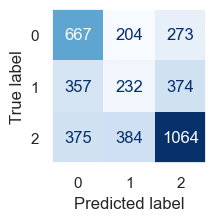

In [27]:
logistic_Grid_CV(model_df1, 'result', oversampler = True)

#### Train on model with feature engineering which reflect paired advantages

In [28]:
model_df2 = pd.read_csv('../dataset/model_df2.csv')

In [29]:
print(model_df2.shape)
model_df2.head()

(16187, 10)


,result,offence_box_adv,offence_GK_adv,defence_box_adv,defence_GK_adv,offence_pass_adv,offence_move_adv,defence_pass_adv,defence_move_adv,offence_misc_adv
0,win,0.991337,0.903061,1.188616,1.213864,1.070371,1.055491,1.129365,0.939151,1.111281
1,win,0.986403,0.948087,0.958295,1.124031,0.857672,1.019841,1.031083,0.659104,1.009207
2,win,1.034116,0.974389,1.463961,1.603912,1.085814,1.315606,1.202458,1.028301,1.187167
3,tie,0.899281,1.003717,0.985615,1.219231,0.815437,1.097571,0.919066,0.803688,0.880322
4,lose,0.955704,0.868966,1.185132,1.311599,0.972593,1.392121,1.130798,0.979385,1.015217


              precision    recall  f1-score   support

        lose       0.48      0.46      0.47      1191
         tie       0.23      0.06      0.09       979
         win       0.55      0.78      0.65      1877

    accuracy                           0.51      4047
   macro avg       0.42      0.43      0.40      4047
weighted avg       0.45      0.51      0.46      4047



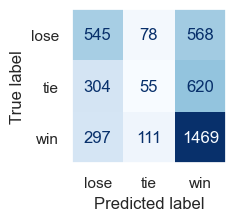

            Feature  Importance
0  offence_misc_adv    0.128479
1  offence_pass_adv    0.121703
2  defence_pass_adv    0.118543
3   offence_box_adv    0.110660
4   defence_box_adv    0.106864
5    offence_GK_adv    0.105659
6  defence_move_adv    0.103877
7  offence_move_adv    0.103140
8    defence_GK_adv    0.101076


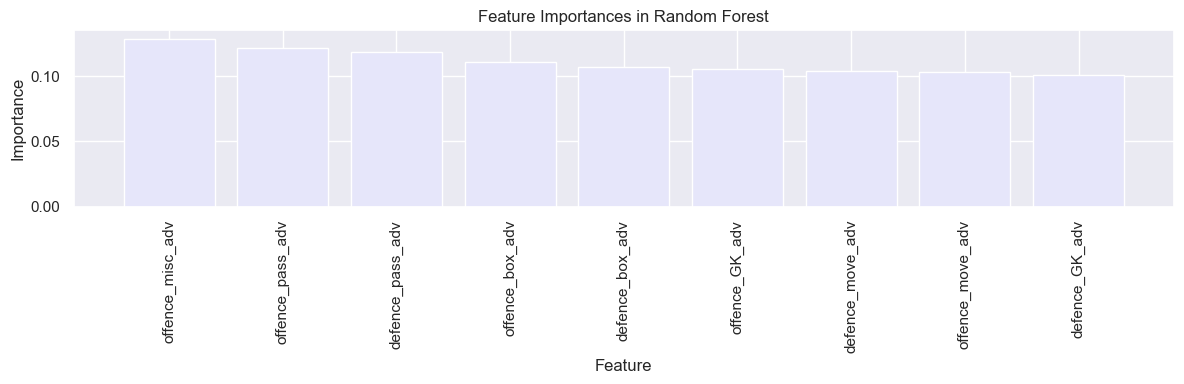

In [30]:
get_importance(model_df2, 'result')

The distribution of importance are close to each other

In [31]:
model_df2['result'] = model_df2['result'].replace({'win': 2, 'tie': 1, 'lose':0})
model_df2['result'] = model_df2['result'].astype('category')

In [32]:
X = model_df2.drop(columns = 'result')

bin_edges_dict = {}
num_bins = 20
bin_labels = range(20)
for col in X.columns:
    model_df2[col], bin_edges = pd.qcut(model_df2[col], labels = bin_labels, 
                                            q=num_bins, retbins=True)
    bin_edges_dict[col] = bin_edges
    #bin_edge_df = pd.DataFrame(zip(bin_edges, bin_labels), columns=['Threshold', 'Tier'])
    #print(bin_edge_df)

LogisticRegression
              precision    recall  f1-score   support

           0       0.44      0.59      0.51      1191
           1       0.29      0.18      0.22       979
           2       0.62      0.61      0.62      1877

    accuracy                           0.50      4047
   macro avg       0.45      0.46      0.45      4047
weighted avg       0.49      0.50      0.49      4047

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.45      0.48      0.47      1191
           1       0.26      0.14      0.18       979
           2       0.58      0.69      0.63      1877

    accuracy                           0.50      4047
   macro avg       0.43      0.44      0.43      4047
weighted avg       0.46      0.50      0.47      4047

GaussianNB
              precision    recall  f1-score   support

           0       0.44      0.60      0.51      1191
           1       0.28      0.17      0.21       979
           2       0.6

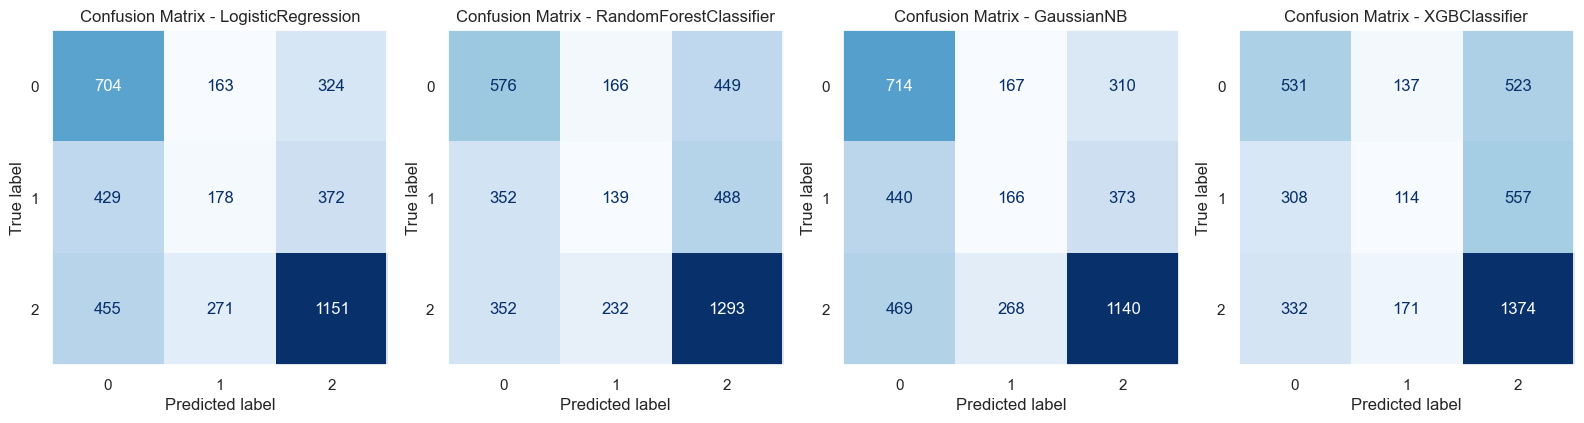

In [33]:
get_best_model(model_df2, 'result', oversampler = True)

Best hyperparameters: {'C': 0.01, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.45      0.59      0.51      1191
           1       0.29      0.18      0.22       979
           2       0.62      0.62      0.62      1877

    accuracy                           0.50      4047
   macro avg       0.45      0.46      0.45      4047
weighted avg       0.49      0.50      0.49      4047



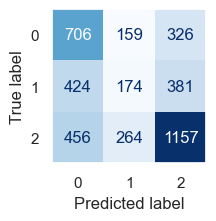

In [34]:
logistic_Grid_CV(model_df2, 'result', oversampler = True)

Summary: 

- The model with engineered features that reflect paired advantage performs similiar with the model with plain stats
- For the plain stats model, the most important features are: defence_CB_home, passing_MF_away, passing_MF_home,
  defence_CB_away, shooting_ST_away, defence_SB_home, shooting_ST_home, defence_SB_away, passing_SB_away, passing_SB_home,  passing_W_home
- For the engineered model, the most important features are: offence_misc_adv, offence_pass_adv, defence_pass_adv, offence_box_adv